![Image of Vizsla](https://storage.googleapis.com/kaggle-competitions/kaggle/7327/logos/header.png)

# Dog Breed Identification - Part 1 - EDA

Who's a good dog? Who likes ear scratches? Well, it seems those fancy deep neural networks don't have all the answers. However, maybe they can answer that ubiquitous question we all ask when meeting a four-legged stranger: what kind of good pup is that?

In this competition, we are provided a strictly canine subset of ImageNet in order to practice fine-grained image classification, we will have to determine the breed of a dog in an image, out of 120 different breeds.

The size of the dataset is 10222 samples divided to 120 classes.<br>
At first, I executed a script to divide the images into 120 folders which represent each class. <br>

The dimensions of images in this dataset vary. All the images are colored so they have 3 channels (RGB).
We can see that the dimensions of each sample are different so it's not really ready for use. Therofore, we will need to preproccess the dateset and change the dimensions to some default size, or either create a model that is able to handle this variety.

We also see that the samples contain some noise, which is expressed in other artifacts in the images (a human next to a dog, trees, etc.). We can address that by excluding some 'bad' samples, as it's important to have high quality samples in the dataset to get good results. 

Having a large dataset is crucial for good performance. We see that we only have 10222 samples, a relatively small amount considering the fact that we need to clasify these samples into 120 classes.  
In order to get more data samples, we will use augmentation and make minor alterations to our existing dataset. Minor changes such as flips, translations or rotations.

I used the following kinds of augmentation, which I decided would be valid for this task:

Flip: we can flip the images horizontally. Doing this will not change the image perception, as the images will just face the other side.

Rotation: we can rotate the images in various angles. One key thing to note is that image dimensions may not be preserved after rotation. We will address it by filling the points outside the boundaries of the input.

Zoom: We can zoom randomly inside images or randomly translate images vertically and horizontally, within a specific range. 

Shear: We can also apply shearing transformations and change some graphics into something else by applying rules.

In order to understand how our augmentation method is changing our data lets explore the changes it added to the original image.

In [1]:
#testing imageGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
)
#loading image
img = load_img('../DogBreedDataSet/train/vizsla/0c4ac597d196aaf07f3af039b8fd6925.jpg')  # this is a PIL image
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the save_to_dir directory
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='AugmentedVizsla', save_prefix='augmentedVizsla', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

Using TensorFlow backend.


Here are all the images that were created using our generator and a Vizsla dog model.

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


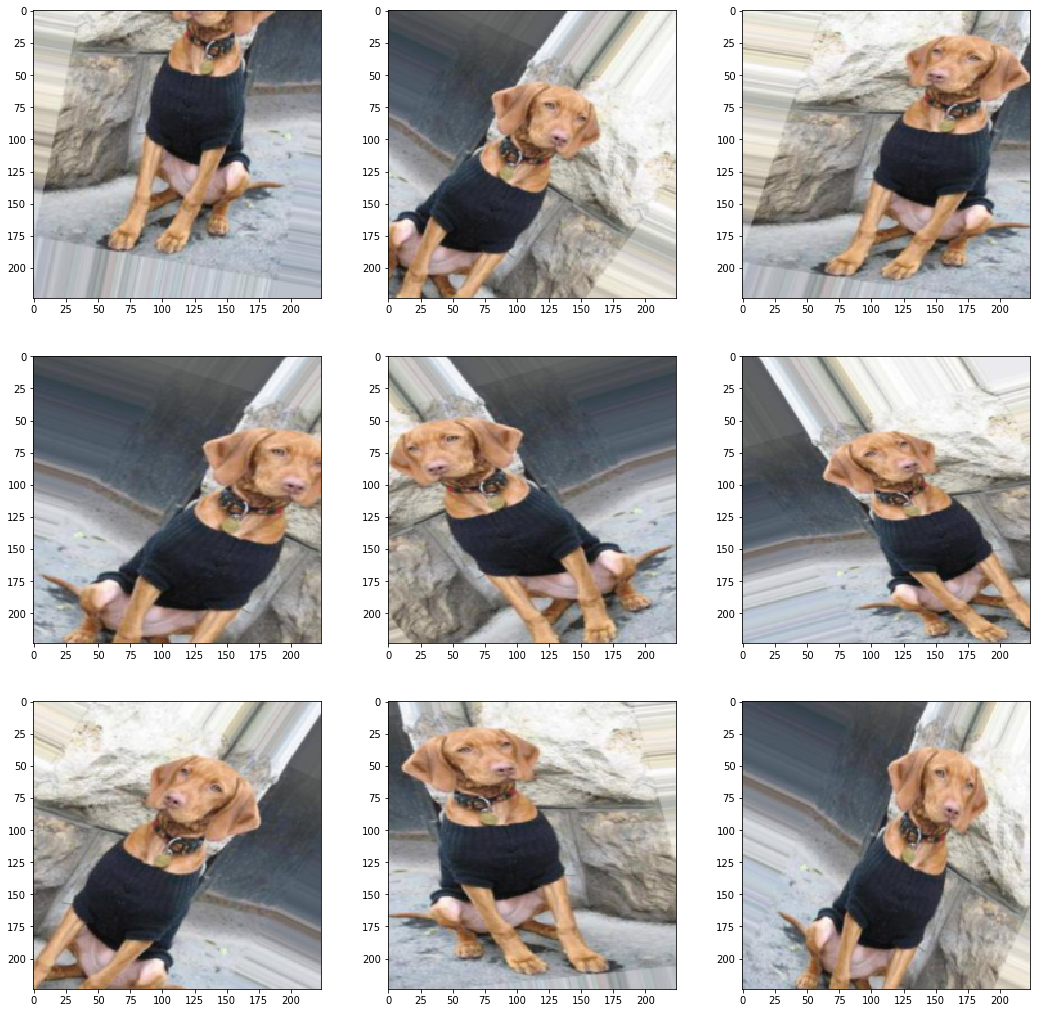

In [3]:
%matplotlib inline
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_multiple_imgs(data,nrows=4,ncols=4,figsize=(18,18)):
    fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    for i in range(nrows*ncols):
        ax[i%nrows,i//nrows].imshow(data[i])

def read_and_resize_single_img(filename,nrow=224,ncol=224,channels=3):
    from scipy import misc
    arr = misc.imread(filename)
    arr = misc.imresize(arr,size=(nrow,ncol,channels))
    return arr
 
viszlasArray = np.zeros((36,224,224,3))
i=0
for f in os.listdir(".\AugmentedVizsla"):
    arr=read_and_resize_single_img(f'.\AugmentedVizsla\{f}')
    if len(arr.shape)<3: arr = np.stack([arr,arr,arr],axis=-1) #change to use np.repeat() for more generalizable
    viszlasArray[i] = np.float16(arr)
    i+=1
    # breaking so id theres more images in augmented folder our array will not flow out of bound
    if i==35:
        break;

plot_multiple_imgs(viszlasArray/255,3,3)

Nice, We got 9 similar but different images.

Next We would like to check how many samples there are from each of the 120 classes in order to understand if the data is balanced. We'll see below a histogram of the dog breeds and the distribution of the samples over the target 120 classes:  

In [67]:
import os
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display, Image
from IPython.core.display import HTML

%matplotlib inline

In [2]:
import pandas as pd
tr_data = pd.read_csv('../labels.csv')

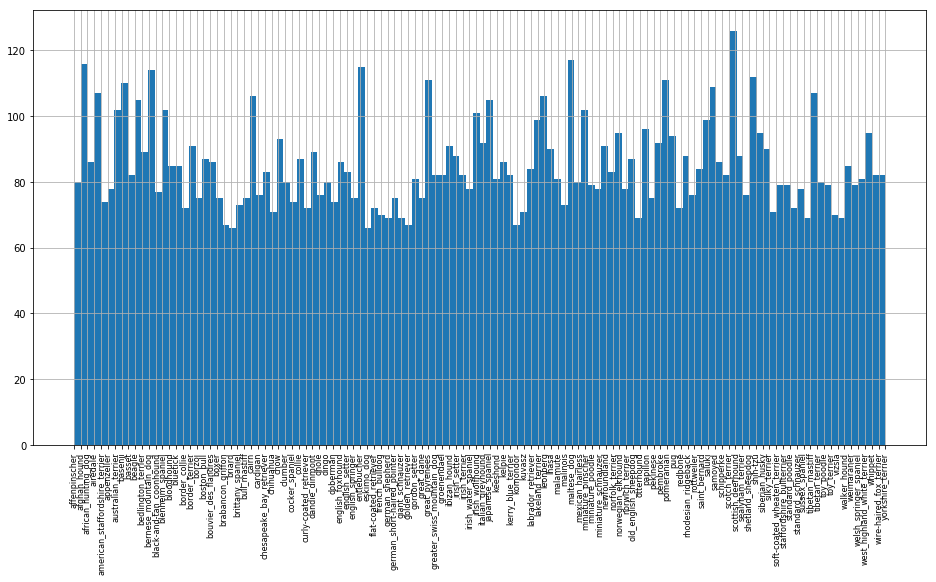

In [5]:
# Use the built-in DataFram function `hist` to plot a histogram of the dog breeds.
hist = tr_data['breed'].hist(figsize=(16, 8), bins=120, xrot=90, xlabelsize=8)
plt.show()

In [3]:
print('The sample count of each of the target classes is:')
print(tr_data.iloc[:,-1].value_counts())

The sample count of each of the target classes is:
scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
great_pyrenees                    111
pomeranian                        111
basenji                           110
samoyed                           109
tibetan_terrier                   107
airedale                          107
leonberg                          106
cairn                             106
japanese_spaniel                  105
beagle                            105
miniature_pinscher                102
blenheim_spaniel                  102
australian_terrier                102
irish_wolfhound                   101
lakeland_terrier                   99
saluki                             99
papillon                           96
norwegian_elkhound                 95
siberian_husky                     95

We see that the data is not balanced well. Every class has a different amount of samples, which varies between 66 and 126 samples per class. 

## Benchmark

Convolutional neural network is by all accounts the best machine learning model for image classification, but in this case, there are not enough training examples to train it. It would not be able to learn generic enough patterns off this dataset to classify different dog breeds. Most likely, it will just overfit to this small amount of training examples so that accuracy on the test set will be low.

There are two possible approaches to address this:

-Merge dogs dataset with another bigger dataset with images and train a CNN on these merged examples.
This approach has two big downsides: a much bigger amount of data has to be analyzed and the training on this big dataset will take much more time and resources.

-Take an already pre-trained deep neural network on a larger dataset, cut into it, and attach an additional “classification head” i.e. several additional fully connected layers with the Softmax layer on top of them.


Almost every approach emphasized that the original ImageNet set has quite a few different dog classes so it's recommended to reuse CNNs with pretrained ImageNet weights. This way the prediction is much faster (<1s/image) making it possible to run meaningful experiments.
It appears that with modern machine learning frameworks (like TensorFlow) and pre-trained models for image recognition, the task could be solved with a pretty good accuracy without applying too many efforts and spending too much time and resources.

Here is a specific approach example, reusing CNN with pretrained weights:
An image is fed into Inception model. The output from Inception model goes through several fully connected (FC) layers, and finally the softmax outputs probabilities of an image to belong to each class. Inception model remains frozen with already predefined model parameters.
After executing 5K epochs, the metrics had the following values, when both errors pretty low on both test and training set:
cost = 0.1
Test Error = 2.7%
Train Error = 2.5%

Some other pre-trained deep neural network that may be used:
resnet50, vgg16, xception, inception resnet, inception v3

Below we can see the public leader board of the Kaggle competition, while the score column reffers to the multiclass loss:

Populating the interactive namespace from numpy and matplotlib


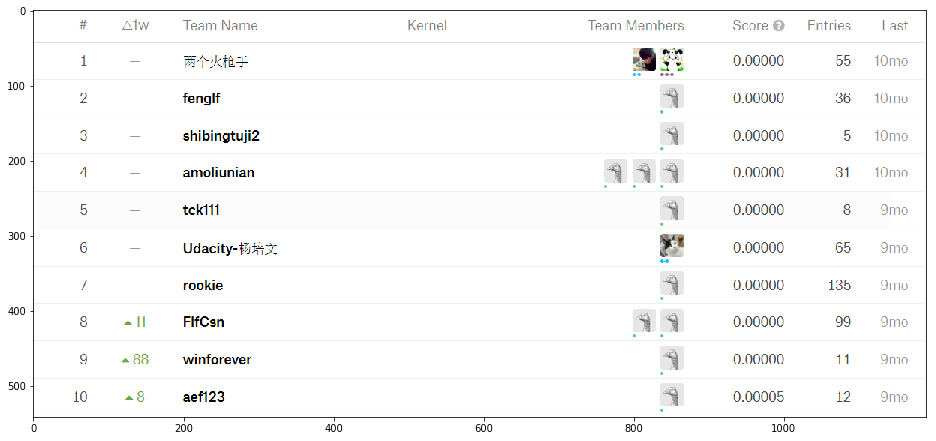

In [16]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(16,9))
img=mpimg.imread('.\pics\KaggleLeaderBoard.PNG')
imgplot = plt.imshow(img)
plt.show()

In addittion, most of the approaches we saw, encourage preproccessing the samples in order to improve the training proccess. 

## A picture is worth a thousand words



Here we can see some examples from similar categories which are hard to separate:

### Siberian Husky:

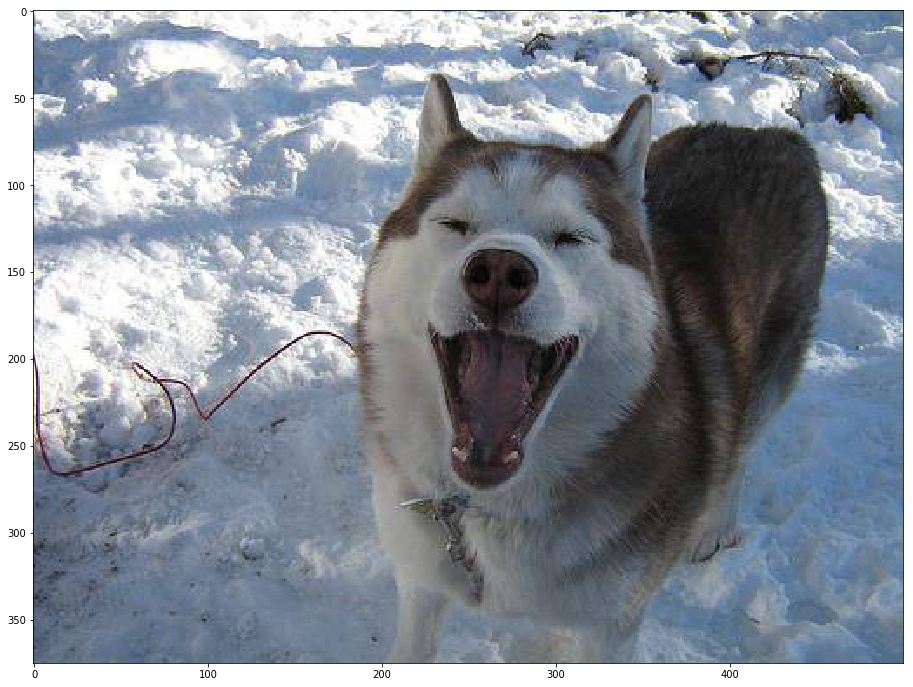

In [10]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/siberian_husky/7972d0467f6a8d6f209f948347061e24.jpg')
imgplot = plt.imshow(img)
plt.show()


## Eskimo Dog:

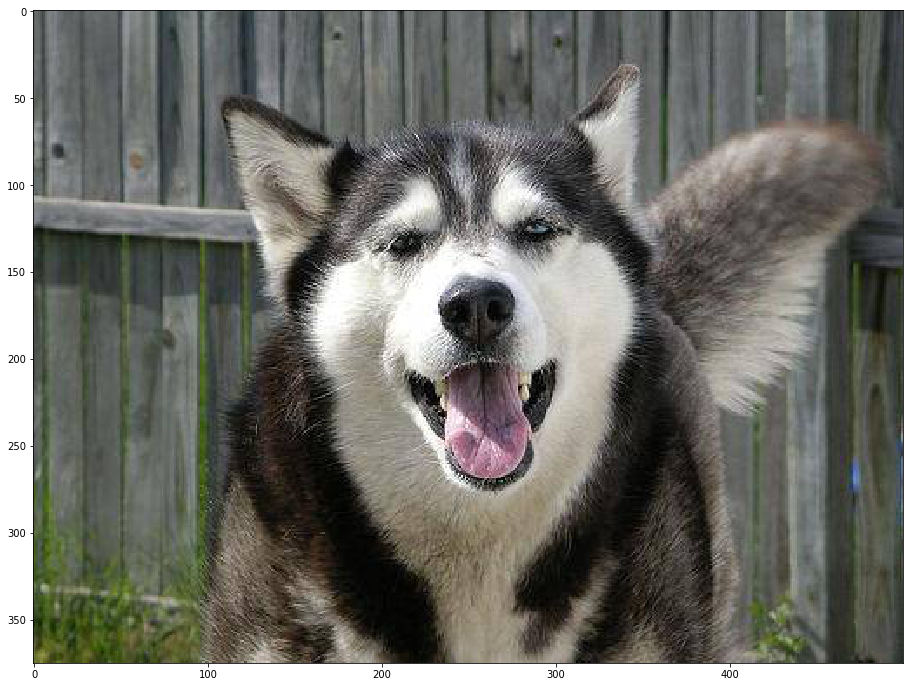

In [11]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/eskimo_dog/c9579c8fd920a1e698c696168946a83b.jpg')
imgplot = plt.imshow(img)
plt.show()


### Malamute:

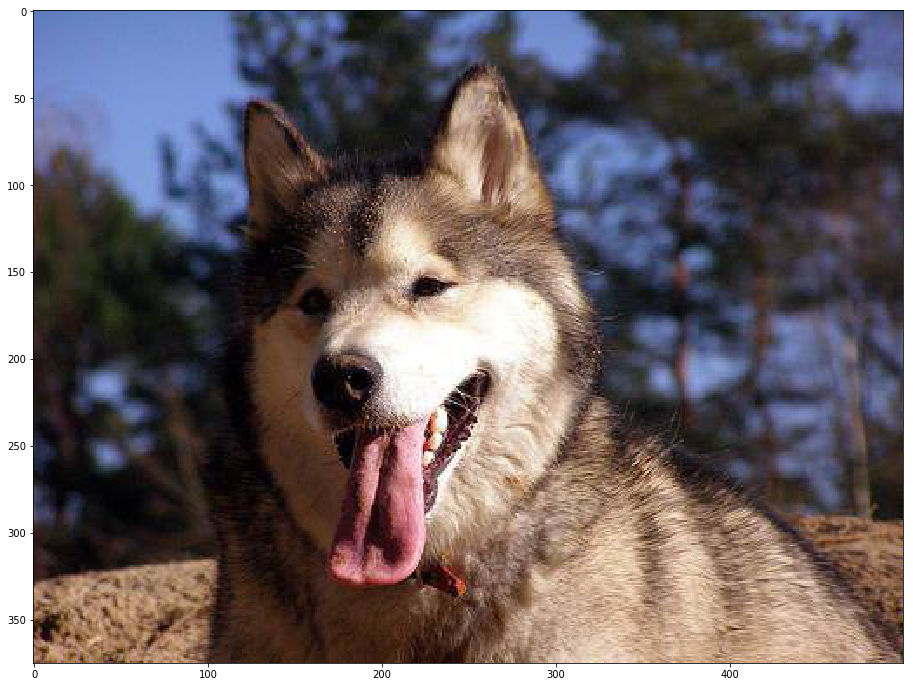

In [12]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/malamute/ed1957de19321d3f09348c0c1e3321a8.jpg')
imgplot = plt.imshow(img)
plt.show()


And on the other hand here are some examples from very different categories which are much more easier to separate:

### Boxer:

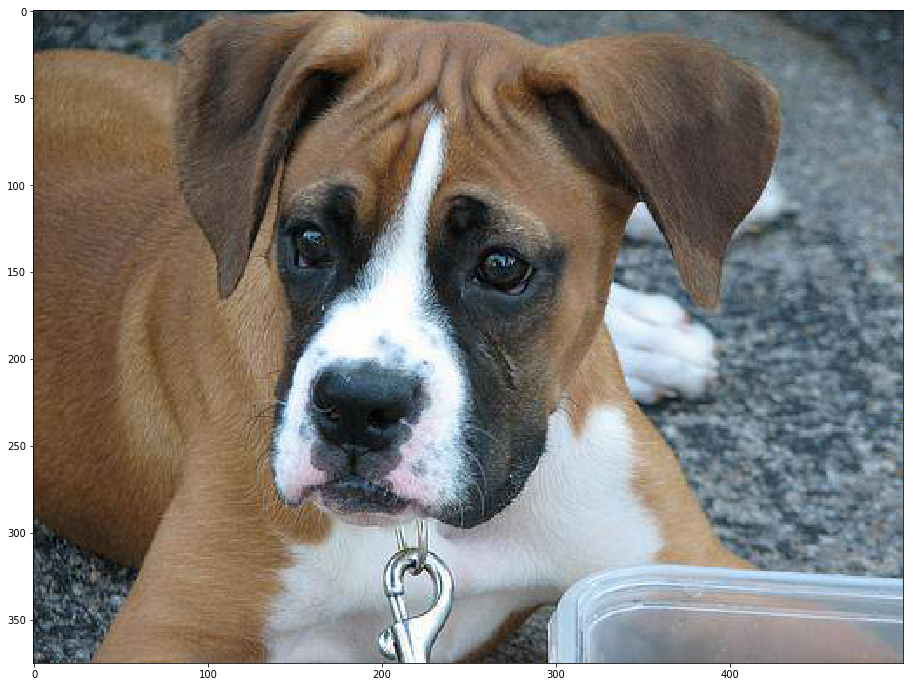

In [14]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/boxer/39eb055caee27cc3110ad26459fb64f9.jpg')
imgplot = plt.imshow(img)
plt.show()


### Afghan Hound:

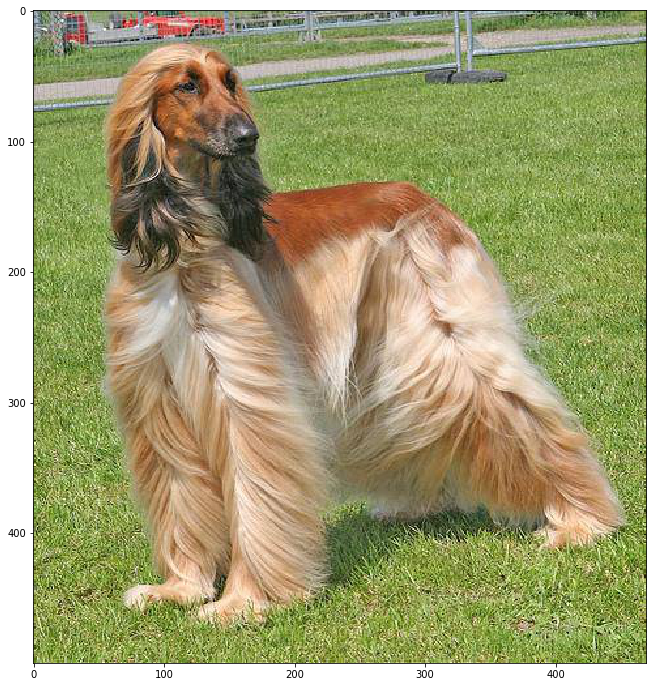

In [13]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/afghan_hound/2a59a96ffbdd6c8ba70465e3a7e10a3c.jpg')
imgplot = plt.imshow(img)
plt.show()
